## How does bushfire affect aquatic ecosystems in NSW?

In [1]:
import os
import geopandas as gp
import shapely
import fiona
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.ticker as ticker
import folium

In [2]:
shp_file_name = r"gda2020\nsw_localities.shp"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = (
    "https://data.gov.au/data/dataset/"
    "91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
    "5e295412-357c-49a2-98d5-6caf099c2339/download/"
    "nsw_locality_polygon_shp.zip"
)

In [3]:
%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (10, 5)

In [5]:
saved_style_state = matplotlib.rcParams.copy()

In [71]:
if os.path.isfile("bushfire-water-quality-dataset.csv"):
    filepath = "bushfire-water-quality-dataset.csv"
    print("loading from file")
else:
    filepath = "https://data.nsw.gov.au/search/dataset/ds-nsw-ckan-9e9b4c96-1a68-4dea-a5b0-23dd4cba9839/details?q="
    print("loading from the internet")
bushfire_data = pd.read_csv(filepath)
print("done")

loading from file
done


In [72]:
file_path = 'gda2020/nsw_localities.shp'
gdf = gp.read_file(file_path)

In [73]:
burbs = gp.GeoDataFrame.from_file(file_path)
burbs.set_crs(epsg=5234, inplace=True, allow_override=True)
burbs.sample()

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
2445,lcp4749263a89dd,loc2f1d9edec2f4,2021-06-24,Longueville,Gazetted Locality,NSW,"POLYGON ((151.175 -33.828, 151.175 -33.828, 15..."


In [74]:
addreses = [f"{x}, Australia" for x in bushfire_data.Estuary.unique()]
estuary_loc_df = gp.tools.geocode(addreses)
estuary_loc_df["Estuary"] = bushfire_data.Estuary.unique()
estuary_loc_df
# getting the points for the locations of lakes in NSW

,geometry,address,Estuary
0,POINT (150.48912 -35.2698),"Lake Conjola, 2539, New South Wales, Australia",Lake Conjola
1,POINT (150.30111 -35.64833),"Durras Lake, New South Wales, Australia",Durras Lake
2,POINT (152.46843 -32.01202),"Khappinghat Creek, 2430, Australia",Khappinghat Creek
3,POINT (150.38514 -35.48396),"Meroo Lake, 2539, Australia",Meroo Lake
4,POINT (150.38755 -35.46131),"Termeil Lake, 2539, Australia",Termeil Lake
5,POINT (150.11384 -36.31759),"Lake Tilba Tilba, 2546, Australia",Tilba Tilba Lake
6,POINT (152.48614 -32.38441),"Smiths Lake, 2428, Australia",Smiths Lake
7,POINT (150.01689 -36.6099),"Wapengo Lake, Australia",Wapengo Lake
8,POINT (150.0671 -36.3705),"Wallaga Lake, 2546, Bega Valley Shire Council,...",Wallaga Lake
9,POINT (149.93029 -37.23272),"Wonboyn Lake, Australia",Wonboyn Lake


In [69]:
lake_df = bushfire_data.merge(estuary_loc_df, on="Estuary", how="inner")
lake_df.head()
# merging the points into a geometry column in the data set

,Date,Time Frame,Estuary,Zone,Dissolved oxygen (% saturation),Salinity (psu),pH,Chlorophyll-a (ug/L),"Blue green algae (BGA, ug/L)",Turbidity (NTU),fDOM (RFU),Dissolved nitrogen (ug/L),Total nitrogen (ug/L),Dissolved phosphorus (ug/L),Total phosphorus (ug/L),"Nitrogen oxides (NOx, ug/L)","Ammonia (NH3, ug/L)","Phosphate (PO4 3-, ug/L",geometry,address
0,2017-10-31,Pre-fire,Lake Conjola,1,102.1,33.0,7.97,2.63,5.56,1,3.0,208.4,326.5,12.34,22.600,1.00000,3.0000,0.0000,POINT (150.48912 -35.2698),"Lake Conjola, 2539, New South Wales, Australia"
1,2017-10-31,Pre-fire,Lake Conjola,2,104.4,34.0,8.05,1.5,2.32,0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (150.48912 -35.2698),"Lake Conjola, 2539, New South Wales, Australia"
2,2017-11-23,Pre-fire,Lake Conjola,1,96.9,33.0,7.92,2.5,6.15,1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (150.48912 -35.2698),"Lake Conjola, 2539, New South Wales, Australia"
3,2017-11-23,Pre-fire,Lake Conjola,2,98.1,34.0,8,1.06,2.39,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (150.48912 -35.2698),"Lake Conjola, 2539, New South Wales, Australia"
4,2017-12-19,Pre-fire,Lake Conjola,1,100.3,34.0,7.8,2.61,3.56,1,4.0,225.7,287.7,-1.97426,6.388,0.03515,0.2326,0.6248,POINT (150.48912 -35.2698),"Lake Conjola, 2539, New South Wales, Australia"


In [70]:
bushfire_data = pd.read_csv(
    filepath,
    infer_datetime_format=True,
    parse_dates=["Date"],
    dayfirst=True, 
)
bushfire_data.head(2)

/tmp/ipykernel_18056/2336673582.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  bushfire_data = pd.read_csv(


,Date,Time Frame,Estuary,Zone,Dissolved oxygen (% saturation),Salinity (psu),pH,Chlorophyll-a (ug/L),"Blue green algae (BGA, ug/L)",Turbidity (NTU),fDOM (RFU),Dissolved nitrogen (ug/L),Total nitrogen (ug/L),Dissolved phosphorus (ug/L),Total phosphorus (ug/L),"Nitrogen oxides (NOx, ug/L)","Ammonia (NH3, ug/L)","Phosphate (PO4 3-, ug/L"
0,2017-10-31,Pre-fire,Lake Conjola,1,102.1,33.0,7.97,2.63,5.56,1,3.0,208.4,326.5,12.34,22.6,1.0,3.0,0.0
1,2017-10-31,Pre-fire,Lake Conjola,2,104.4,34.0,8.05,1.5,2.32,0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
date_format_pattern = "%B, %Y"
earliest_date = datetime.strftime(bushfire_data.Date.min(), date_format_pattern)
latest_date = datetime.strftime(bushfire_data.Date.max(), date_format_pattern)

How does bushfires affect the aquatic ecosystems in lakes of NSW?

Dataset: "2019/2020 Bushfire Inquiry project water quality dataset" from data.nsw.gov.au

Published by NSW Department of Climate Change, Energy, the ENvironment and Water on 31 May 2024

The dataset compiles the chang in levels of NSW lakes pre and post the 2019/2020 fire, with data ranging back to 2013 until 2023. The data explores different aspects that determines the suitability of water quality to aquatic ecosystems. 

### `Bushfire`

### What is a bushfire and how did it occur in Australia in 2019-20?

Bushfire is a wildfire that burns in areas with wild vegetation. They occur due to hot and dry weather and can exponentially spread through lands, making it hard to control. September of 2019 was the start of the fire. It worsened through the months as Australia was approaching its summer, where the temperature heightened and a drought continued. Strong winds intensified the severity of the bushfire. A rainstorm then came in mid-February which extinguished a majority of the fire. By March, the fire was fully extinguished or contained. 

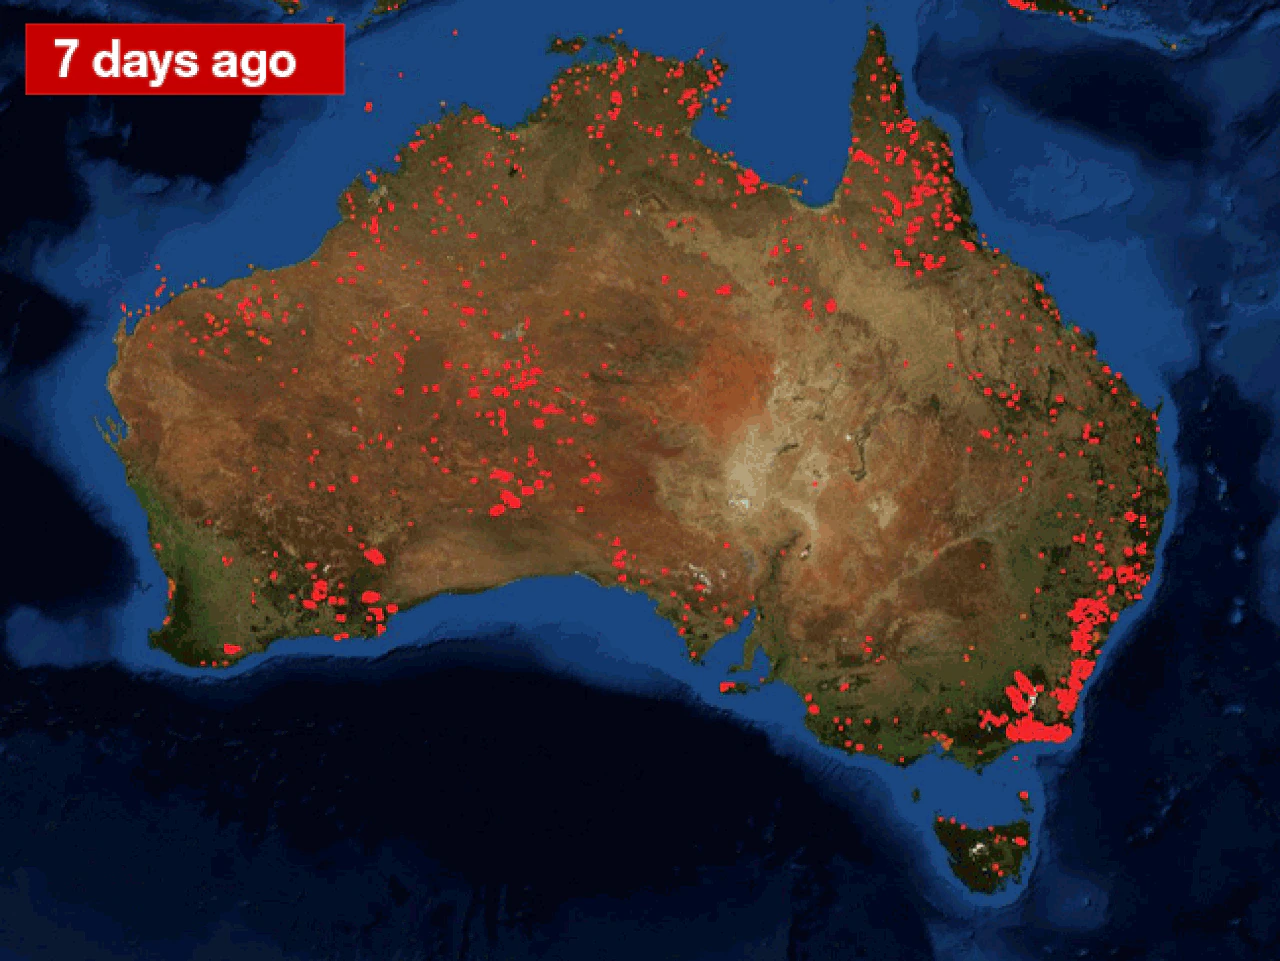

Figure 1: Australia bushfire affected area, 06-01-2020


In [16]:
from IPython.display import Image

with open("australia bushfire.webp", "rb") as file:
    display(Image(file.read()))
    print("Figure 1: Australia bushfire affected area, 06-01-2020")

In [87]:
bushfire_data.Estuary.unique()

array(['Lake Conjola', 'Durras Lake', 'Khappinghat Creek', 'Meroo Lake',
       'Termeil Lake', 'Tilba Tilba Lake', 'Smiths Lake', 'Wapengo Lake',
       'Wallaga Lake', 'Wonboyn Lake'], dtype=object)

The 10 lakes listed are lakes spread across NSW, as seen on the map below. 

Text(0.5, 1.0, 'Map of Lakes in NSW')

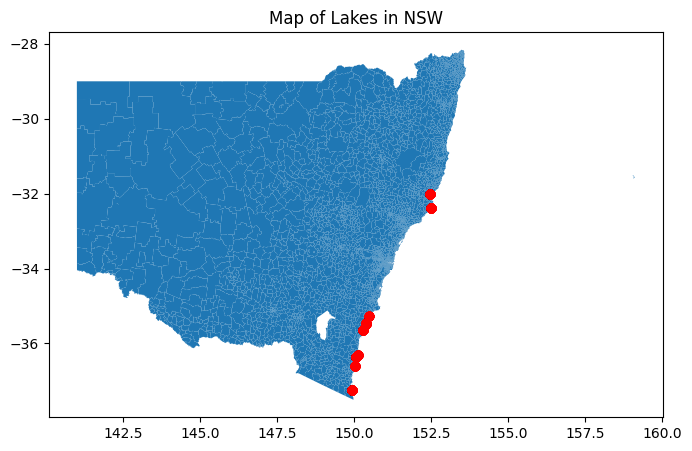

In [75]:
ax = burbs.plot()
gp.GeoDataFrame(lake_df).geometry.plot(ax=ax, c="r")
plt.title("Map of Lakes in NSW")

Text(0.5, 1.0, 'Map of Lakes in NSW')

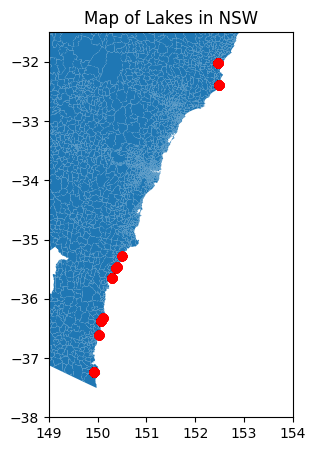

In [76]:
ax = burbs.plot()
ax.set_xlim(left=149, right=154)
ax.set_ylim(top=-31.5, bottom=-38)
gp.GeoDataFrame(lake_df).geometry.plot(ax=ax, c="r")
plt.title("Map of Lakes in NSW")

When looking at this map and the bushfire map (Figure 1) side by side, there is an overlapping of red points. During the bushfire of 2019 - 2020, areas affected were surrounding and including the lakes of NSW. 

In [20]:
bushfire_data['Time Frame'] = bushfire_data['Time Frame'].astype(str)

num_cols = bushfire_data.columns.difference(['Time Frame', 'Estuary'])

bushfire_data[num_cols] = bushfire_data[num_cols].apply(pd.to_numeric, errors='coerce')

average_pre_fire = (
    bushfire_data[bushfire_data["Time Frame"] == "Pre-fire"].groupby("Estuary")[num_cols].mean()
)
average_dur_fire = (
    bushfire_data[bushfire_data["Time Frame"] == "During fire"].groupby("Estuary")[num_cols].mean()
)
average_post_fire = (
    bushfire_data[bushfire_data["Time Frame"] == "Post-fire"].groupby("Estuary")[num_cols].mean()
)

In [21]:
def plot_estuary_data(df, estuary_name, column_name):
    estuary_df = df[df["Estuary"] == estuary_name].dropna(subset=[column_name])
    plt.plot(
        estuary_df["Date"],
        estuary_df[column_name],
        label=f"{estuary_name}",
    )

bushfire_data['Date'] = pd.to_datetime(bushfire_data['Date'])
bushfire_data.sort_values('Date', inplace=True)

### How did the water quality in these lakes change?

Green-blue Algae

In [22]:
def algae_line():
    estuaries = [
        "Lake Conjola",
        "Durras Lake",
        "Khappinghat Creek",
        "Meroo Lake",
        "Termeil Lake",
        "Tilba Tilba Lake",
        "Smiths Lake",
        "Wapengo Lake",
        "Wallaga Lake",
        "Wonboyn Lake",
    ]
    
    plt.figure()
    for estuary in estuaries:
        column = "Blue green algae (BGA, ug/L)"
        plot_estuary_data(bushfire_data, estuary, column)
    
    plt.title("Total Blue Green Algae Levels Over Time")
    plt.xlabel("Date")
    plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
    plt.ylabel(column)
    
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.gca().tick_params(axis="y", which="major", labelsize=10)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    return

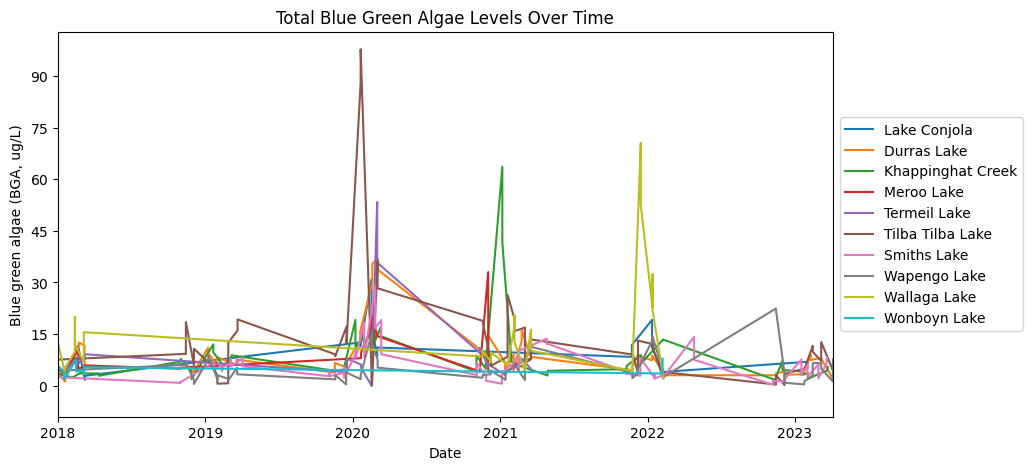

In [23]:
algae_line()

Ever since the bushfire happened, spikes in blue green algae levels were recorded from multiple lakes throughout NSW. 

What are they and why are their significant?

Blue-green algae, also known as a microscopic bacteria named Cyanobacteria, are commonly found in bodies of water such as rivers, lakes, and dams. They are a natural threat to water quality due to a phenomenon called 'algal blooms', where they rapidly multiply into an unhealthy amount. They produce various types of toxins (hepatoxins, neurotoxins, and endotoxins) that are not only harmful to aquatic behaviour but also for human health. 

The algaes first reached its peak in 2020, right around the time the Bushfires were ongoing. It then also heightened a few more times in the continuing years. However, the correlation between the appearance of the bushfires and the influx in blue algae are not apparent from this graph alone. 

### So, how does blue-green algal blooms tie back to the bushfires?

1. fDOM

In [24]:
def fDOM():
    fDOM_data = pd.DataFrame({
        'Pre-fire': average_pre_fire["fDOM (RFU)"],
        'Post-fire': average_post_fire["fDOM (RFU)"]
    })
    
    fDOM_data.plot(kind='bar', figsize=(10, 6))
    
    plt.title('Pre-fire vs Post-fire fDOM Levels')
    plt.xlabel('Estuary')
    plt.ylabel('fDOM (RFU)')
    
    plt.show()
    print("fDOM: Fluorescent Dissolved Organic Matter")
    return

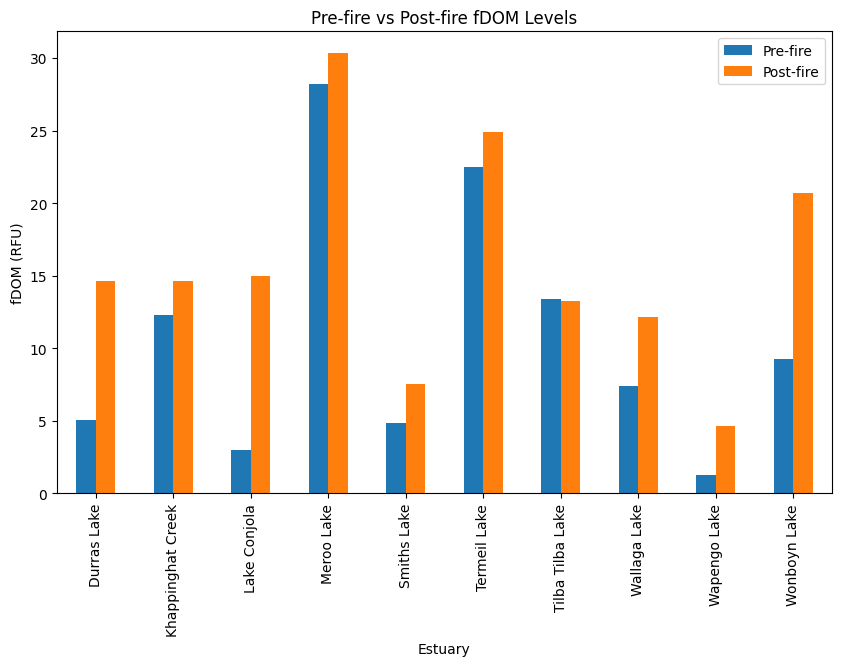

fDOM: Fluorescent Dissolved Organic Matter


In [25]:
fDOM()

A visible impact of bushfire was how it altered NSW's vegetation and soil. A lot of runoffs from this event went into the waters, introducing organic compounds from soils and vegetations into the lakes. The influx of organic materials mainly alter two main aspects of water, which are color and light availibility. 

2. Nitrogen & Phosphorus Levels

In [30]:
def nitrogen_line():
    estuaries = [
        "Lake Conjola",
        "Durras Lake",
        "Khappinghat Creek",
        "Meroo Lake",
        "Termeil Lake",
        "Tilba Tilba Lake",
        "Smiths Lake",
        "Wapengo Lake",
        "Wallaga Lake",
        "Wonboyn Lake",
    ]
    
    dates = bushfire_data["Date"]
    healthy_minrange = [100] * len(dates)
    healthy_maxrange = [500] * len(dates)
    
    plt.figure()
    for estuary in estuaries:
        plot_estuary_data(bushfire_data, estuary, "Total nitrogen (ug/L)")
    
    plt.plot(dates, healthy_minrange, label="Custom Line 1", color='blue', alpha=0.1)
    plt.plot(dates, healthy_maxrange, label="Custom Line 2", color='blue', alpha=0.1)
    
    plt.fill_between(dates, healthy_minrange, healthy_maxrange, color='blue', alpha=0.2, label='Highlighted Area')
    
    plt.title("Nitrogen Levels Over Time")
    plt.xlabel("Date")
    plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
    plt.ylabel("Total nitrogen (ug/L)")
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.gca().tick_params(axis="y", which="major", labelsize=10)
    plt.show()
    return

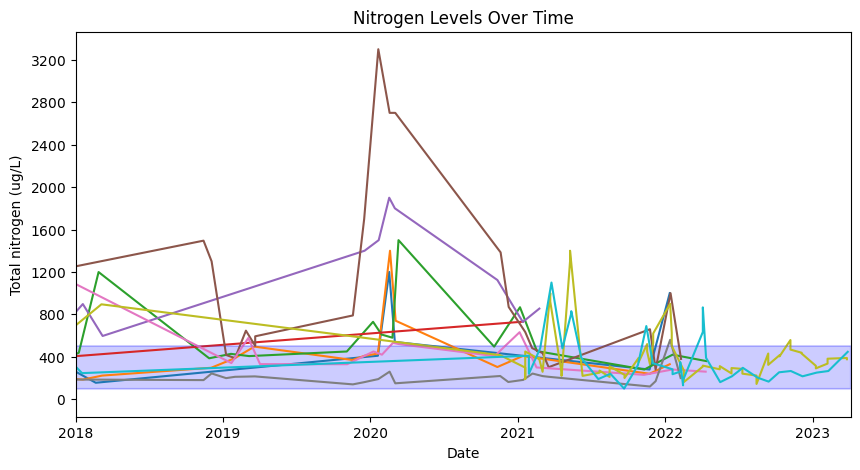

In [31]:
nitrogen_line()

In [32]:
def phosphorus_line():
    estuaries = [
        "Lake Conjola",
        "Durras Lake",
        "Khappinghat Creek",
        "Meroo Lake",
        "Termeil Lake",
        "Tilba Tilba Lake",
        "Smiths Lake",
        "Wapengo Lake",
        "Wallaga Lake",
        "Wonboyn Lake",
    ]
    
    dates = bushfire_data["Date"]
    healthy_minrange = [5] * len(dates)
    healthy_maxrange = [50] * len(dates)
    
    plt.figure()
    for estuary in estuaries:
        plot_estuary_data(bushfire_data, estuary, "Total phosphorus (ug/L)")
    
    plt.plot(dates, healthy_minrange, color='blue', alpha=0.1)
    plt.plot(dates, healthy_maxrange, color='blue', alpha=0.1)
    
    plt.fill_between(dates, healthy_minrange, healthy_maxrange, color='blue', alpha=0.2)
    
    plt.title("Phosphorus Levels Over Time")
    plt.xlabel("Date")
    plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
    plt.ylabel("Total phosphorus (ug/L)")
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.gca().tick_params(axis="y", which="major", labelsize=10)
    plt.show()
    return

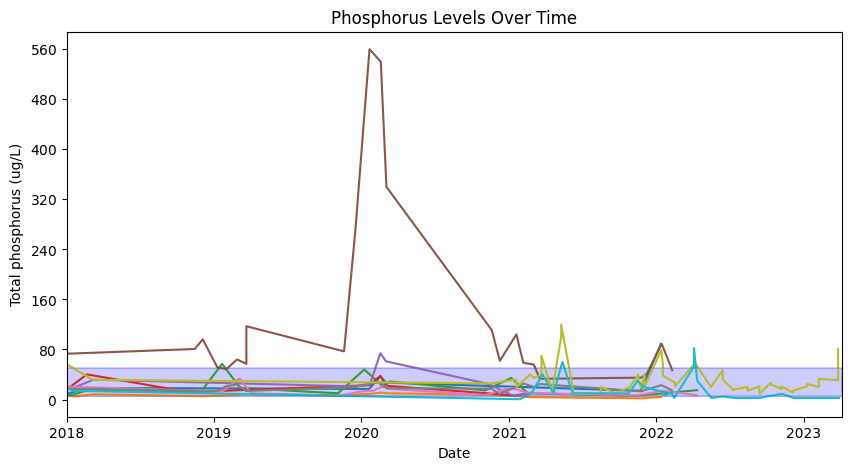

In [33]:
phosphorus_line()

Runoffs from vegetation and soil also leads to nutrient loading, where it releases high amount of nitrogen and phoshporus into lakes. Nutrient levels in lakes become exponentially higher, creating an inbalance in water composition. These nutrients act as a fertilizer for algaes, boosting their growth and triggering the algal blooms. Generally, the high and lows of levels appear in relatively similar time periods for the two chemicals. However, the peaks reached by the lakes are alarming as they often go out of the normal recommended range (highlighted by the blue area). While phosphorus levels stuck inside of the range more often, nitrogen levels peaked very often. Both levels reached far high during 2020 which could indicate its correlation to the high amounts of runoffs entering the waters during the occurance of bushfires. 

In [40]:
def tilba_nitrogen():
    dates = bushfire_data["Date"]
    healthy_minrange = [100] * len(dates)
    healthy_maxrange = [500] * len(dates)

    estuaries = [
        "Tilba Tilba Lake",
    ]
    
    plt.figure()
    for estuary in estuaries:
        column = "Total nitrogen (ug/L)"
        plot_estuary_data(bushfire_data, estuary, column)
    
    plt.plot(dates, healthy_minrange, label="Custom Line 1", color='blue', alpha=0.1)
    plt.plot(dates, healthy_maxrange, label="Custom Line 2", color='blue', alpha=0.1)
    
    plt.fill_between(dates, healthy_minrange, healthy_maxrange, color='blue', alpha=0.2, label='Highlighted Area')
    
    plt.title("Nitrogen Levels Over Time")
    plt.xlabel("Date")
    plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
    plt.ylabel(column)
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.gca().tick_params(axis="y", which="major", labelsize=10)
    plt.show()
    return

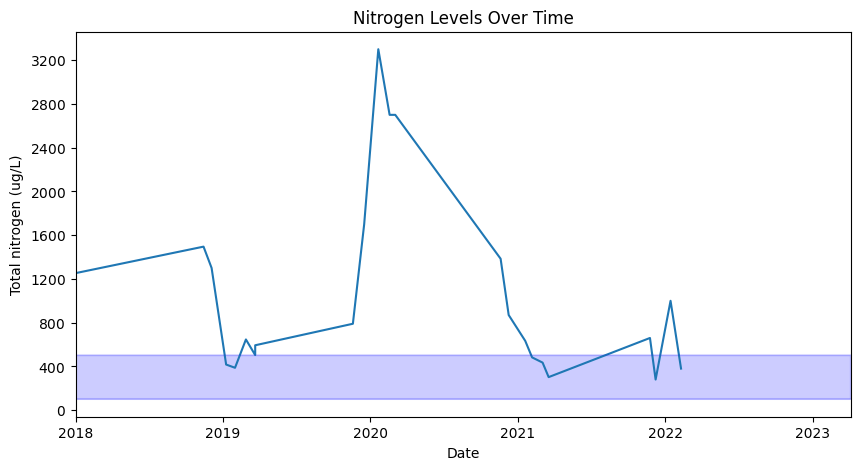

In [41]:
tilba_nitrogen()

In [44]:
def tilba_phosphorus():
    dates = bushfire_data["Date"]
    healthy_minrange = [5] * len(dates)
    healthy_maxrange = [50] * len(dates)
    
    plt.figure()
    for estuary in estuaries:
        plot_estuary_data(bushfire_data, "Tilba Tilba Lake", "Total phosphorus (ug/L)")
    
    plt.plot(dates, healthy_minrange, color='blue', alpha=0.1)
    plt.plot(dates, healthy_maxrange, color='blue', alpha=0.1)
    
    plt.fill_between(dates, healthy_minrange, healthy_maxrange, color='blue', alpha=0.2, label='Highlighted Area')
    
    plt.title("Phosphorus Levels Over Time")
    plt.xlabel("Date")
    plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
    plt.ylabel("Total phosphorus (ug/L)")
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.gca().tick_params(axis="y", which="major", labelsize=10)
    plt.show()
    return

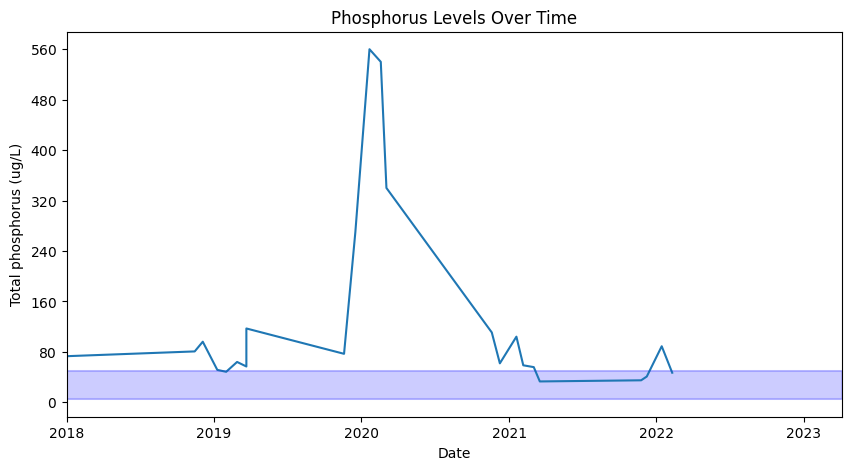

In [45]:
tilba_phosphorus()

The peaks of nitrogen and phosphorus for the Tilba Tilba lake stood out the most, with approximately 3200 and 560 ug/L in 2020 respectively. This means that in 2020, nitrogen levels were 6 times and phosphorus levels were 11 times the maximum of the normal range. At other times, the levels only touched the normal range around the start of 2019 and the middle of 2021-2022. Thus, the nutrients supplied to algaes during 2020 are at an all time high and could drastically affect the balance of the aquatic ecosystem. 

### We've gone over the cause of algal blooms,

### How about its impacts to the lakes?

Blue-green algae: Chlorophyll levels

A sign of an algal bloom is a lake's turbidity. Turbidity refers to the cloudiness of a liquid, mainly due to the levels of small particles that are invisible to the naked eye. Turbidity can hint on the amount of light that can reach the bottom of the lake. As the lake becomes more cloudy, submerged aquatic plants and species receive inadequate amount of light, impeding biological processes such as photosynthesis.

The influx in fDOM is also apparent through the levels of turbidity, due to the increase in particles from runoffs pushed into the waters. Thus, fDOM and turbidity go hand in hand, and turbidity is directly proportional to fDOM.

In this case, turbidity is not only affected by fDOM, but also from algal bloom.

In [46]:
def chloro_algae():
    filtered_estuary_data = bushfire_data[bushfire_data['Estuary'].isin(estuaries)]
    
    datec_data = filtered_estuary_data.groupby('Date')['Chlorophyll-a (ug/L)'].mean().reset_index()
    dateb_data = filtered_estuary_data.groupby('Date')['Blue green algae (BGA, ug/L)'].mean().reset_index()
    
    
    plt.figure()
    plt.plot(datec_data['Date'], datec_data['Chlorophyll-a (ug/L)'], label='Chlorophyll-a')
    plt.plot(dateb_data['Date'], dateb_data['Blue green algae (BGA, ug/L)'], label='Blue-green algae')
    
    plt.title("Average Chlorophyll-a & Blue-green Algae Levels Over Time")
    plt.xlabel("Date")
    plt.xlim(pd.Timestamp("2018"), bushfire_data['Date'].max())
    plt.ylabel("Levels (ug/L)")
    
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.gca().tick_params(axis="y", which="major", labelsize=10)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    return

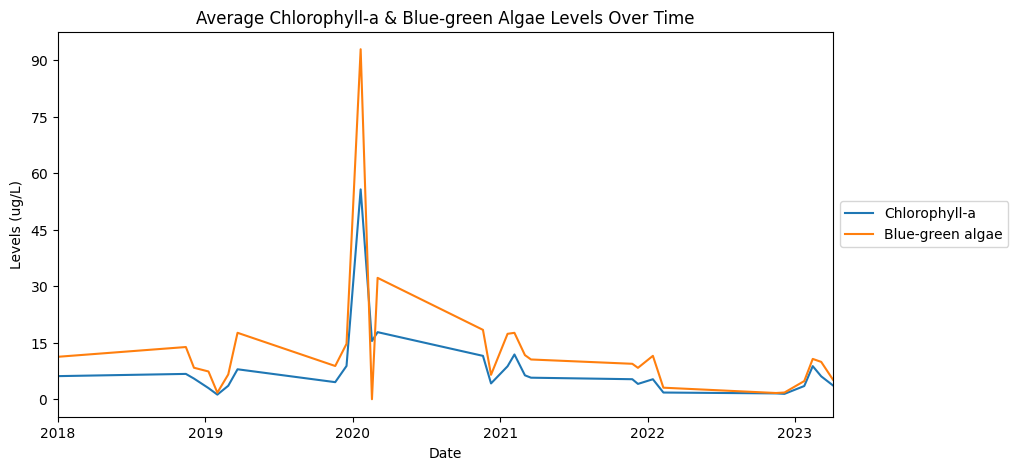

In [47]:
chloro_algae()

Chlorophyll-a is a pigment that helps algaes photosynthesize by absorbing light. As chlorophyll-a is a part of blue-green algaes, the trends in levels are almost identical, except for the values that they have. Increased levels can lead to alteration in color and odor of lakes, producing green scums and a bad smell. Lakes that are dominantly green can indicate overproduction of algae. They can reduce light penetration into the lake and affect the aquatic ecosystem.

1. Turbidity

In [48]:
def turbidity_map():
    from IPython.display import display
    
    pre_fire_df = lake_df[lake_df['Time Frame'] == 'Pre-fire']
    post_fire_df = lake_df[lake_df['Time Frame'] == 'Post-fire']
    
    m = folium.Map(location=[-34.5, 151.5], zoom_start=7)
    
    for idx, row in pre_fire_df.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=row['Turbidity (NTU)'] * 1, 
            color='tan',
            fill=True,
            fill_color='tan',
            fill_opacity=0.5,
            popup=f"Pre-fire Turbidity: {row['Turbidity (NTU)']}"
        ).add_to(m)
    
    for idx, row in post_fire_df.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=row['Turbidity (NTU)'] * 1,
            color='brown',
            fill=True,
            fill_color='brown',
            fill_opacity=0.5,
            popup=f"Post-fire Turbidity: {row['Turbidity (NTU)']}"
        ).add_to(m)
    
    display(m)
    return

In [77]:
turbidity_map()

The plot sizes in the maps indicate turbidity levels of each lakes, with the tan colored plot being value for pre-fire and the red plot for post-fire. The turbidity varies for the two time frames, but as the map zooms out, it becomes clearer that post-fire turbidity reaches higher numbers. This could mean that either the levels of fDOM became high after the fire or that the production of algae has increased, or a mix of both. 

In [50]:
def turb_line():
    estuaries = [
        "Lake Conjola",
        "Durras Lake",
        "Khappinghat Creek",
        "Meroo Lake",
        "Termeil Lake",
        "Tilba Tilba Lake",
        "Smiths Lake",
        "Wapengo Lake",
        "Wallaga Lake",
        "Wonboyn Lake",
    ]
    
    plt.figure()
    for estuary in estuaries:
        column = "Turbidity (NTU)"
        plot_estuary_data(bushfire_data, estuary, column)
    
    plt.title(f"{column} Levels Over Time")
    plt.xlabel("Date")
    plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
    plt.ylabel(column)
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.gca().tick_params(axis="y", which="major", labelsize=10)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    return

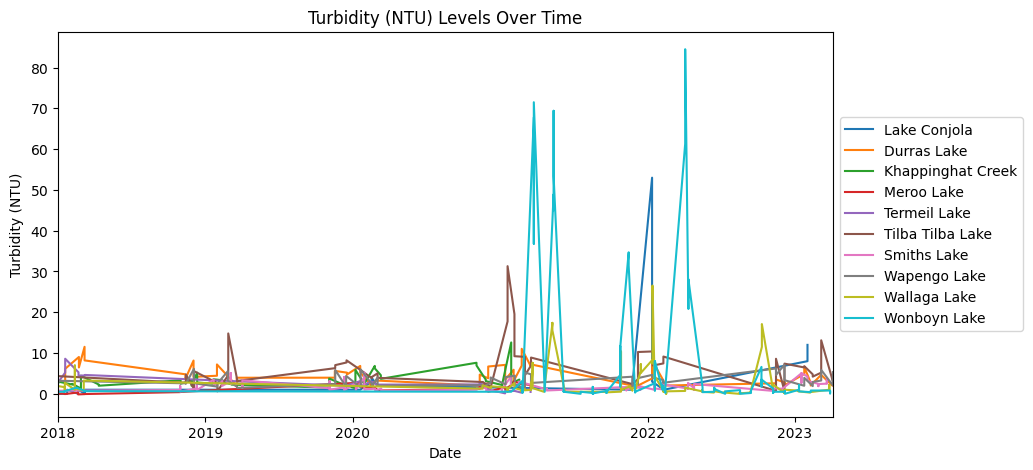

In [51]:
turb_line()

Meanwhile, this graph shows the peaks of turbidity over the years. The latter years shows that turbidity reached its peak after the bushfire. On the other hand, turbidity has always stuck between 0 - 10 NTU, more or less. The post-fire levels are especially high for Wonboyn Lake, which could point to how location may correlate with the severities in impact of the bushfire.

2. Dissolved Oxygen

In [52]:
def oxygen_bar():
    fDOM_data = pd.DataFrame({
        'Pre-fire': average_pre_fire["Dissolved oxygen (% saturation)"],
        'Post-fire': average_post_fire["Dissolved oxygen (% saturation)"],
        'During fire': average_dur_fire["Dissolved oxygen (% saturation)"],
    })
    
    fDOM_data.plot(kind='bar', figsize=(10, 6))
    
    plt.title('Pre-fire vs Post-fire Dissolved Oxygen Levels')
    plt.xlabel('Estuary')
    plt.ylabel('Dissolved oxygen (% saturation)')
    
    plt.show()
    print("'During Fire' values for Conjola, Wallaga and Wonboyn Lake were not supplied in the dataset")
    return

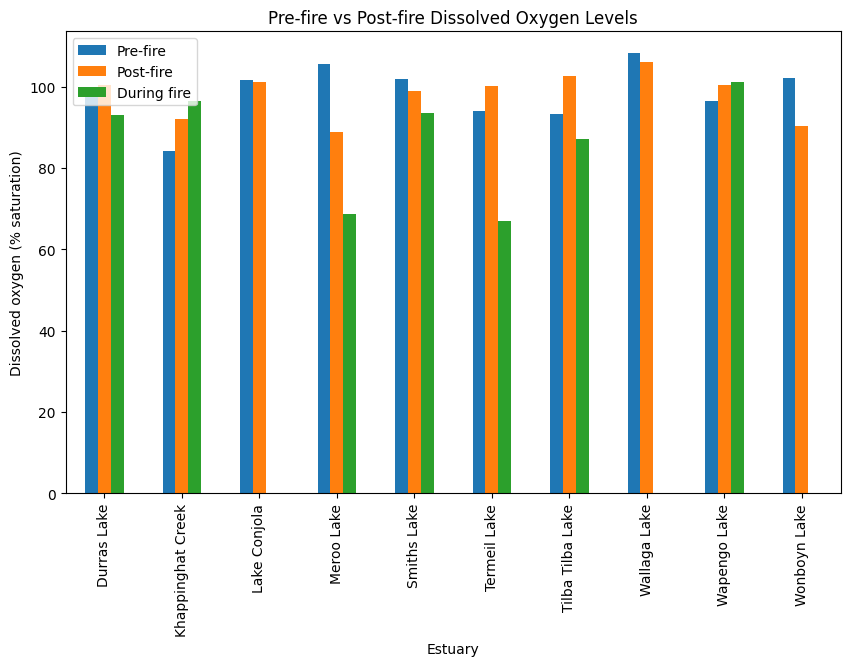

'During Fire' values for Conjola, Wallaga and Wonboyn Lake were not supplied in the dataset


In [53]:
oxygen_bar()

Another impact is the amount of dissolved oxygen avilable in the lakes. The green bar shows that dissolved oxygen levels were particularly low for multiple lakes. This is due to elevated levles of fDOM and pollutants entering waterways that decrease the oxygen levels. Furthermore, the heat from the tall flames rapidly increased the temperature of the lakes, letting oxygen escape out of the water. Furthermore, a factor of algae growth is oxygen. With high Chlorophyll-a levels, dissolved oxygen levels deplete and more algae is produced in return. As a result, aquatic organisms could die out of oxygen depletion. 

Enough of Blue-green Algae... 

How did the bushfire affect the other aspects of the aquatic ecosystem?

1. pH

Bushfire can also change a lake's pH due to the chemicals that enter the waters. pH relates to the acididty and alkalinity of a liquid. pH below 7 is acidic while pH over 7 is alkaline. It is factor that contributes to suitable water quality for the aquatic species in lakes. Drastic changes out of the normal range, as well as changes that occur to quickly may induce physiological stess to species. This may create negative outcomes such as less growth, reproduction and the occurances of diseases. Thus, aquatic lives might be in danger. 

In [54]:
def pH_bar():
    bushfire_data['Date'] = pd.to_datetime(bushfire_data['Date'])
    
    bushfire_data['Year'] = bushfire_data['Date'].dt.year
    
    avg_pH_per_year = bushfire_data.groupby(['Year'])['pH'].mean()
    
    plt.figure(figsize=(12, 6))
    plt.bar(avg_pH_per_year.index, avg_pH_per_year, color='skyblue')
    
    plt.title('Average pH Levels by Year for All Estuaries')
    plt.xlabel('Year')
    plt.ylabel('Average pH Level')
    plt.xticks(avg_pH_per_year.index, rotation=45)
    plt.ylim(min(avg_pH_per_year) - 1, max(avg_pH_per_year) + 1) 
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()
    return

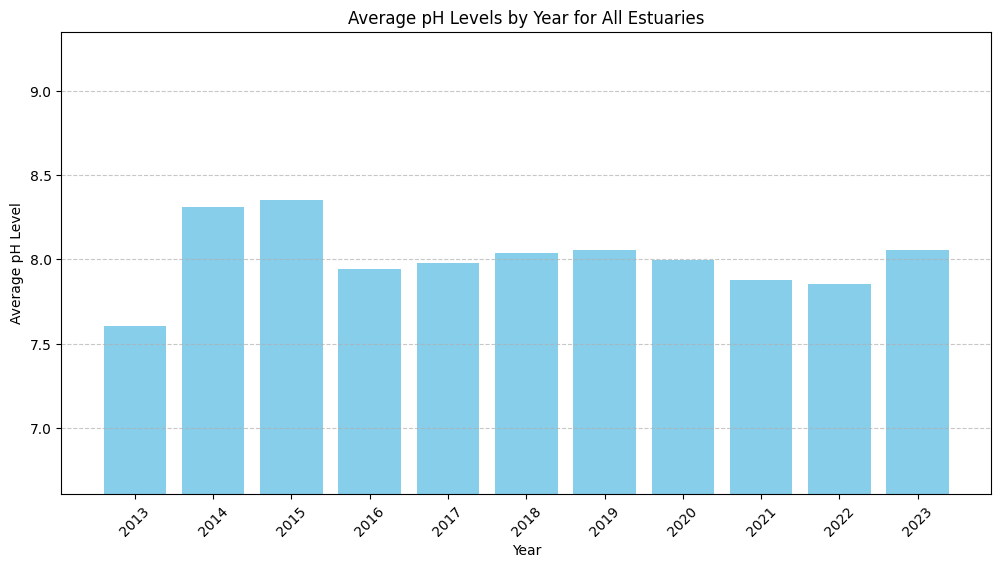

In [55]:
pH_bar()

The bar graph shows that most lakes stay around the 8 mark, other lakes are either more alkaline or acidic. For fresh waters, the general acceptable range is around 6 - 9. The average values  for each years show that the bushfire seems to lower the pH levels, albeit by a slight and safe amount. 

In [56]:
def pH_line():
    estuaries = [
        "Lake Conjola",
        "Durras Lake",
        "Khappinghat Creek",
        "Meroo Lake",
        "Termeil Lake",
        "Tilba Tilba Lake",
        "Smiths Lake",
        "Wapengo Lake",
        "Wallaga Lake",
        "Wonboyn Lake",
    ]
    
    plt.figure()
    for estuary in estuaries:
        column = "pH"
        plot_estuary_data(bushfire_data, estuary, column)
    
    plt.title(f"{column} Levels Over Time")
    plt.xlabel("Date")
    plt.xlim(pd.Timestamp("2018"), bushfire_data["Date"].max())
    plt.ylabel(column)
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.gca().tick_params(axis="y", which="major", labelsize=10)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    return

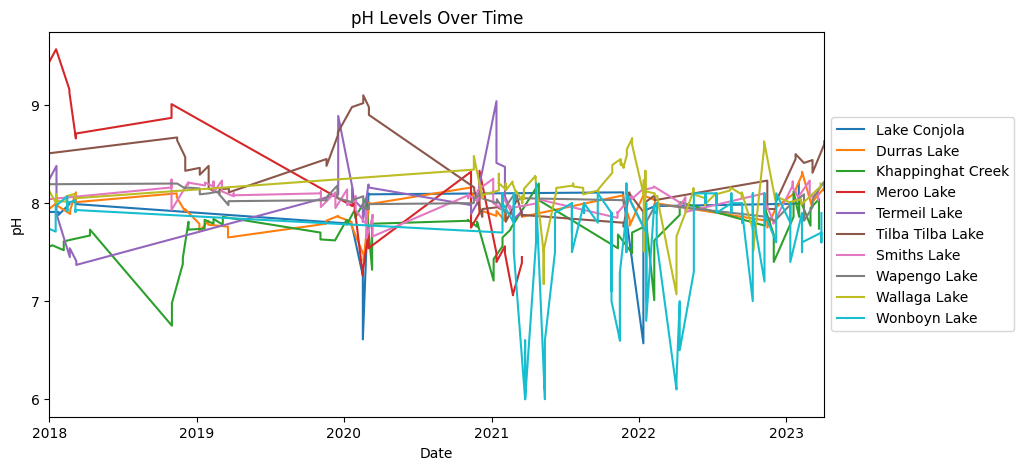

In [57]:
pH_line()

Meanwhile, the line graph shows more detail of the pH changes in each lakes. Rather than the level itself, its instability is worth taking note of. This is evident with the pH levels of Wonboyn lake, which keeps on hovering back and forth around the 6 and 8 mark. Instability can mess with an organism's ability to regulate their internal salt and water balance. Furthermore, it can decrease the amount of oxygen supply by affecting the their solubility in water. 

2. Salinity

levels of dissolved salt in water increases from salt contained soil erosions that go into water. Due to lakes being freshwater, salinity levels are often very low. Increase of salinity that is out of the normal range may induce stress towards aquatic organisms.

In [58]:
def sali_line():
    estuaries = [
        "Lake Conjola",
        "Durras Lake",
        "Khappinghat Creek",
        "Meroo Lake",
        "Termeil Lake",
        "Tilba Tilba Lake",
        "Smiths Lake",
        "Wapengo Lake",
        "Wallaga Lake",
        "Wonboyn Lake",
    ]
    
    plt.figure()
    for estuary in estuaries:
        plot_estuary_data(bushfire_data, estuary, "Salinity (psu)")
    
    plt.title("Salinity Levels Over Time")
    plt.xlabel("Date")
    plt.ylabel("Salinity (psu)")
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.gca().tick_params(axis="y", which="major", labelsize=10)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    return

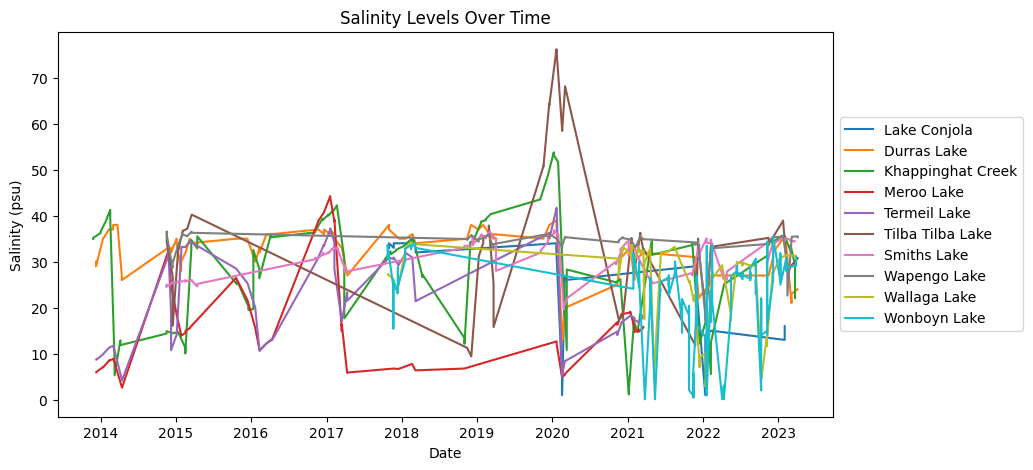

In [59]:
sali_line()

Over the years, the salinity hovers over the low end up to 30 - 40. However, salinity levels in 2020 peaked for Tilba Tilba Lake, reaching more than 70 psu. Khappinghat also shows a salinity increase in 2019-2020, although not as high. Spikes in salinity, nitrogen, and phosphorus levels in Tilba Tilba lake may tie back to high levels of runoffs entering the water. 

In [78]:
column_names = [
    'Dissolved oxygen (% saturation)', 'Salinity (psu)', 'pH', 'Chlorophyll-a (ug/L)',
    'Blue green algae (BGA, ug/L)', 'Turbidity (NTU)', 'fDOM (RFU)', 'Dissolved nitrogen (ug/L)',
    'Total nitrogen (ug/L)', 'Dissolved phosphorus (ug/L)', 'Total phosphorus (ug/L)',
    'Nitrogen oxides (NOx, ug/L)', 'Ammonia (NH3, ug/L)'
]

for col in column_names:
    lake_df[col] = pd.to_numeric(lake_df[col], errors='coerce')
lake_df = lake_df.dropna(subset=column_names)

max_indices = lake_df[column_names].idxmax()
highest_lakes = lake_df.loc[max_indices]

In [79]:
highest_values = lake_df[column_names].max()

highest_lakes = pd.DataFrame()

for col in column_names:
    max_value = highest_values[col]
    lake_with_max_value = lake_df[lake_df[col] == max_value]
    highest_lakes = pd.concat([highest_lakes, lake_with_max_value], ignore_index=True)

In [91]:
from folium.plugins import MarkerCluster

color_scheme = {
    'Dissolved oxygen (% saturation)': 'blue', 
    'Salinity (psu)': 'green', 
    'pH': 'purple', 
    'Chlorophyll-a (ug/L)': 'orange', 
    'Blue green algae (BGA, ug/L)': 'red', 
    'Turbidity (NTU)': 'pink', 
    'fDOM (RFU)': 'darkpurple',
    'Dissolved nitrogen (ug/L)': 'cadetblue', 
    'Total nitrogen (ug/L)': 'beige',
    'Dissolved phosphorus (ug/L)': 'gray',
    'Total phosphorus (ug/L)': 'lightblue',
    'Nitrogen oxides (NOx, ug/L)': 'darkgreen',
    'Ammonia (NH3, ug/L)': 'lightred'
}

m = folium.Map(location=[-34.5, 151.5], zoom_start=7)

marker_cluster = MarkerCluster().add_to(m)

for col in column_names:
    max_value = highest_values[col]
    lake_with_max_value = lake_df[lake_df[col] == max_value]

    for _, row in lake_with_max_value.iterrows():
        color = color_scheme.get(col, 'gray')
        
        popup_text = f"""
        <b>{row['Estuary']}</b><br>
        <b>{col}</b><br>
        <b>Highest Value:</b> {max_value}
        """

        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=folium.Popup(popup_text, max_width=300),
            icon=folium.Icon(color=color)
        ).add_to(marker_cluster)

In [92]:
m

From each columns of the dataset, the highest value has a plot located at the lake it is correlated with. This shows an overview of which lake recieved the most impact from the bushfire, based on the peak of each columns. Three main lakes showing the most impact is the Tilba Tilba Lake, Termeil Lake, and Khappinghat Creek. This map signifies a correlation between the location of the lake to the location of bushfires (refer to figure 1), as well as how to resulted in a higher impact. 

`CONCLUSION`

Due to the bushfire, a chain of reaction happened to the aquatic ecosystems of the lakes in NSW. The most evident reaction being the appearance of algal blooms, especially in lakes that are high in nitrogen and phosphorus levels. Furthermore, changes in levels of pH, dissolved oxygen, and salinity can become factors of stressors for aquatic species, resulting in less reproduction, growth, and occurance of diseases. While this investigation is focused on the effect on aquatic ecosystems, water quality bears a bigger impact not only in the environmental aspect but also in the economic, social, and health aspect, and It could reach as far as the water we consume everyday. 